In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud



In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# Load datasets
fake = pd.read_csv("/content/drive/MyDrive/DataMining Project/Fake.csv")
true = pd.read_csv("/content/drive/MyDrive/DataMining Project/True.csv")

fake["label"] = "Fake"
true["label"] = "Real"

df = pd.concat([fake, true]).sample(frac=1).reset_index(drop=True)

In [4]:
print("Dataset Shape:", df.shape)
print(df['label'].value_counts())

Dataset Shape: (44898, 5)
label
Fake    23481
Real    21417
Name: count, dtype: int64


# 1. Class Distribution

<ipython-input-5-8e14aca06e40>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='label', data=df, palette='Set2')


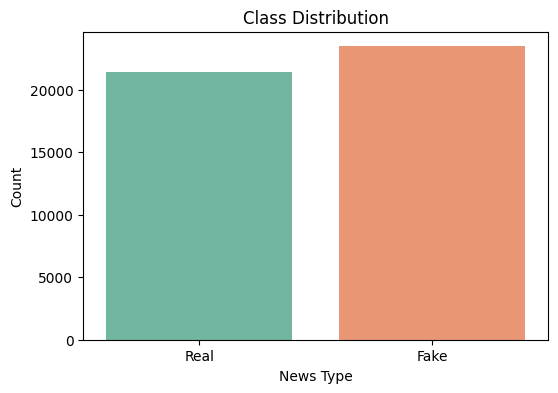

In [5]:

plt.figure(figsize=(6,4))
sns.countplot(x='label', data=df, palette='Set2')
plt.title("Class Distribution")
plt.xlabel("News Type")
plt.ylabel("Count")
plt.show()

# 2. Word Count per Article

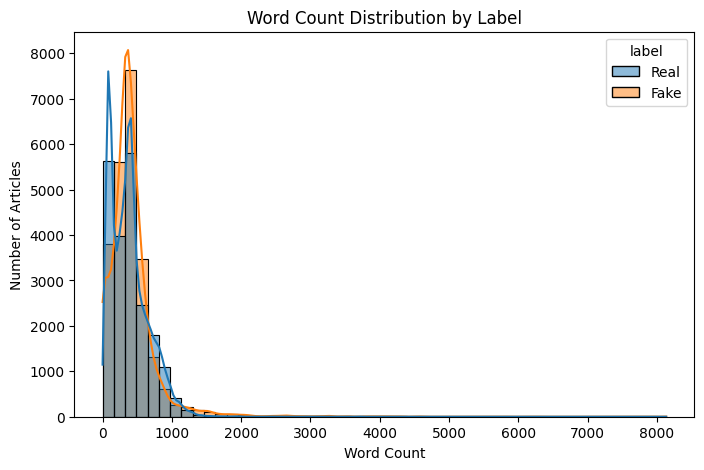

In [6]:
df['word_count'] = df['text'].apply(lambda x: len(str(x).split()))
plt.figure(figsize=(8,5))
sns.histplot(data=df, x='word_count', hue='label', bins=50, kde=True)
plt.title("Word Count Distribution by Label")
plt.xlabel("Word Count")
plt.ylabel("Number of Articles")
plt.show()

# WordClouds

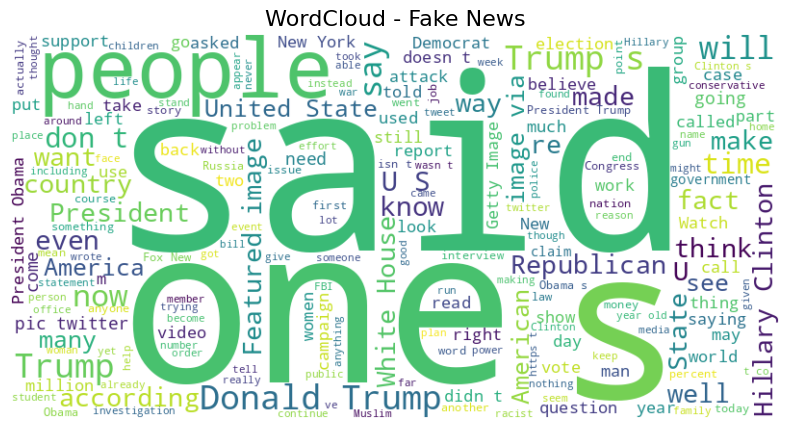

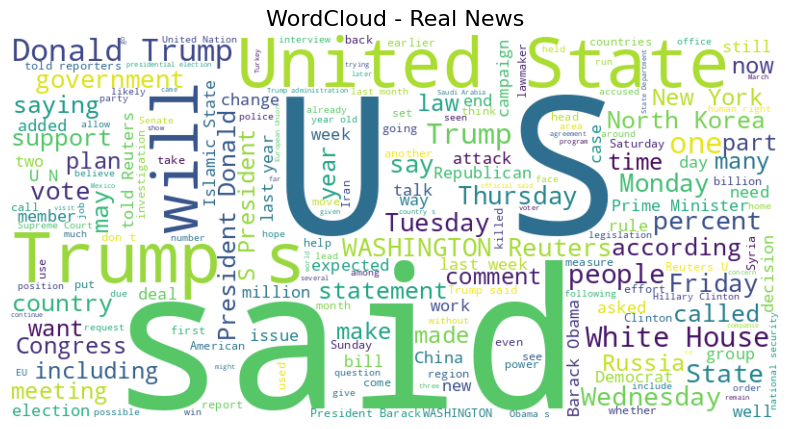

In [7]:

def show_wordcloud(data, title):
    text = ' '.join(data)
    wc = WordCloud(width=800, height=400, background_color='white').generate(text)
    plt.figure(figsize=(10, 5))
    plt.imshow(wc, interpolation='bilinear')
    plt.axis("off")
    plt.title(title, fontsize=16)
    plt.show()

show_wordcloud(fake['text'], "WordCloud - Fake News")
show_wordcloud(true['text'], "WordCloud - Real News")

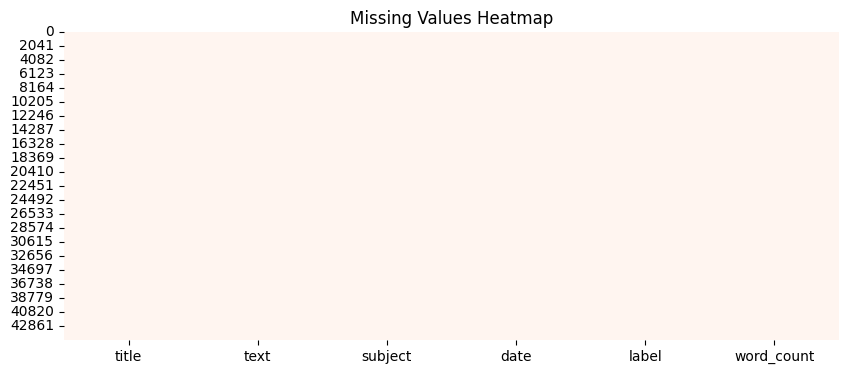

In [8]:
# 4. Missing values heatmap
plt.figure(figsize=(10,4))
sns.heatmap(df.isnull(), cbar=False, cmap='Reds')
plt.title("Missing Values Heatmap")
plt.show()

In [9]:
import numpy as np
import nltk
from nltk.corpus import stopwords
from collections import Counter
import string

In [10]:
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [11]:
# Helper to clean text
def clean_text(text):
    text = str(text).lower()
    text = ''.join([c for c in text if c not in string.punctuation])
    words = text.split()
    words = [w for w in words if w not in stop_words]
    return words

df['clean_words'] = df['text'].apply(clean_text)

#  Average word length per article

/usr/local/lib/python3.11/dist-packages/numpy/_core/fromnumeric.py:3596: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.11/dist-packages/numpy/_core/_methods.py:138: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


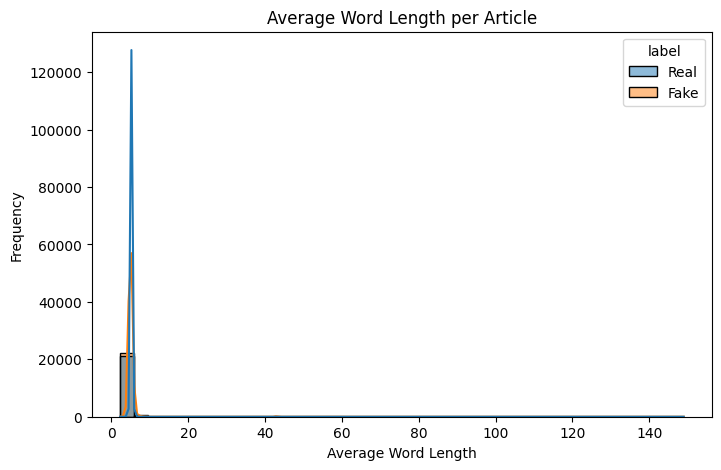

In [12]:
df['avg_word_len'] = df['text'].apply(lambda x: np.mean([len(word) for word in str(x).split()]))

plt.figure(figsize=(8,5))
sns.histplot(data=df, x='avg_word_len', hue='label', bins=40, kde=True)
plt.title("Average Word Length per Article")
plt.xlabel("Average Word Length")
plt.ylabel("Frequency")
plt.show()

# Sentence count

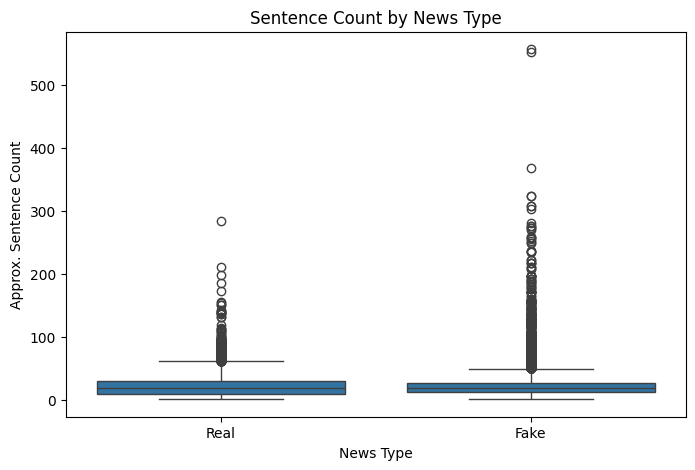

In [13]:
df['sentence_count'] = df['text'].apply(lambda x: len(str(x).split('.')))
plt.figure(figsize=(8,5))
sns.boxplot(data=df, x='label', y='sentence_count')
plt.title("Sentence Count by News Type")
plt.ylabel("Approx. Sentence Count")
plt.xlabel("News Type")
plt.show()

# Top 20 Words

In [14]:
fake_words = [word for text in fake['text'] for word in clean_text(text)]
real_words = [word for text in true['text'] for word in clean_text(text)]

fake_common = Counter(fake_words).most_common(20)
real_common = Counter(real_words).most_common(20)

fake_df = pd.DataFrame(fake_common, columns=['word', 'count'])
real_df = pd.DataFrame(real_common, columns=['word', 'count'])

<ipython-input-15-e36e1b54b73d>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='count', y='word', data=fake_df, palette='Reds_r')


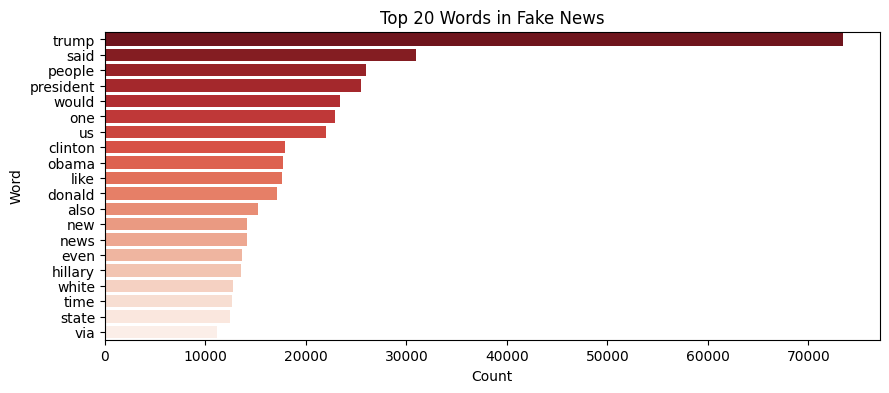

In [15]:
plt.figure(figsize=(10,4))
sns.barplot(x='count', y='word', data=fake_df, palette='Reds_r')
plt.title("Top 20 Words in Fake News")
plt.xlabel("Count")
plt.ylabel("Word")
plt.show()

<ipython-input-16-cf079daf3fbc>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='count', y='word', data=real_df, palette='Blues_r')


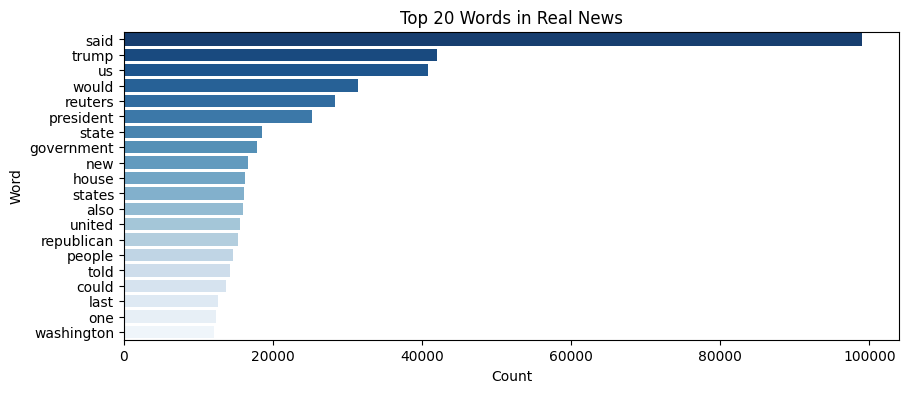

In [16]:
plt.figure(figsize=(10,4))
sns.barplot(x='count', y='word', data=real_df, palette='Blues_r')
plt.title("Top 20 Words in Real News")
plt.xlabel("Count")
plt.ylabel("Word")
plt.show()

# N-Gram Analysis

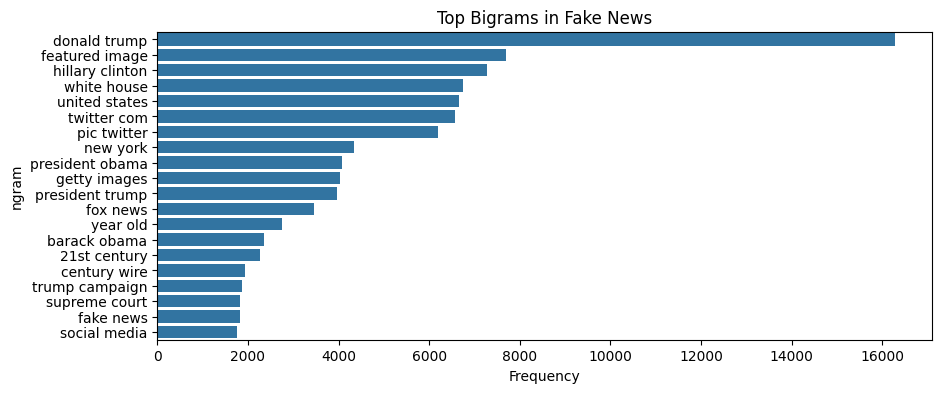

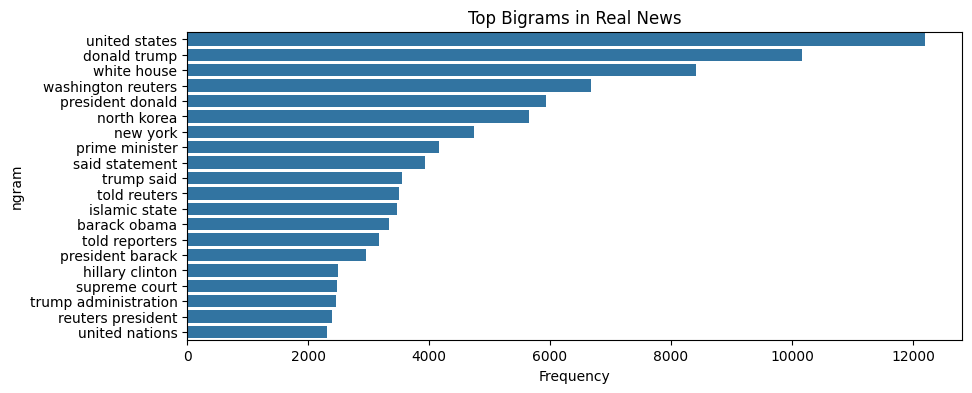

In [17]:
from sklearn.feature_extraction.text import CountVectorizer

def plot_ngrams(texts, ngram_range=(2,2), title="Top N-grams"):
    vec = CountVectorizer(ngram_range=ngram_range, stop_words='english').fit(texts)
    bag_of_words = vec.transform(texts)
    sum_words = bag_of_words.sum(axis=0)
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq = sorted(words_freq, key = lambda x: x[1], reverse=True)[:20]
    df_ngram = pd.DataFrame(words_freq, columns=['ngram', 'count'])

    plt.figure(figsize=(10,4))
    sns.barplot(data=df_ngram, y='ngram', x='count')
    plt.title(title)
    plt.xlabel("Frequency")
    plt.show()

plot_ngrams(fake['text'], (2,2), "Top Bigrams in Fake News")
plot_ngrams(true['text'], (2,2), "Top Bigrams in Real News")


# 4. TF-IDF Feature Importance

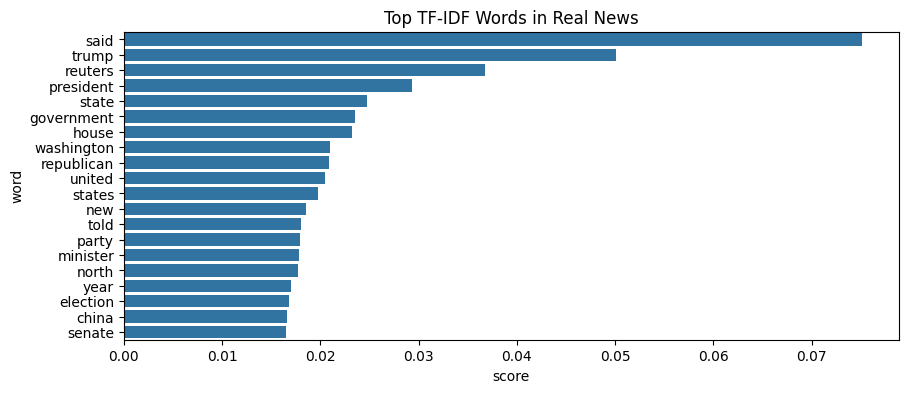

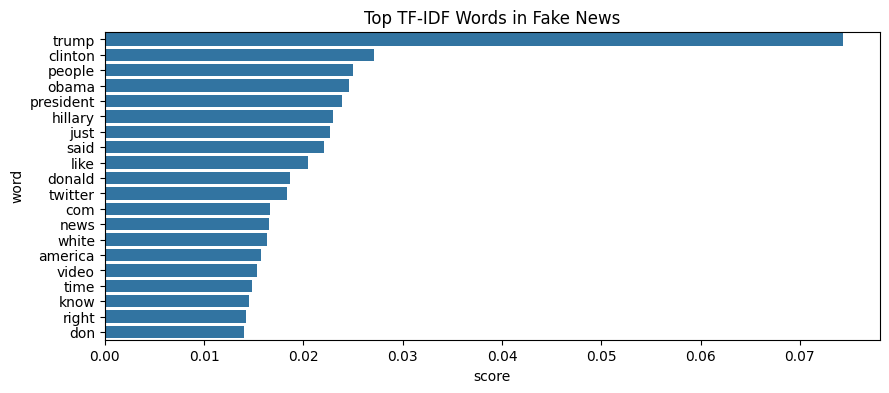

In [20]:
from sklearn.feature_extraction.text import TfidfVectorizer
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Assuming df is already loaded and processed as in your original notebook

tfidf = TfidfVectorizer(stop_words='english', max_features=5000)
X = tfidf.fit_transform(df['text'])
y = df['label'].map({'Fake': 0, 'Real': 1})

# Get top words by class (simplified)
# Convert the boolean pandas Series to a numpy array for indexing the sparse matrix X
real_mean = X[(df['label'] == 'Real').values].mean(axis=0).A1
fake_mean = X[(df['label'] == 'Fake').values].mean(axis=0).A1

feature_names = tfidf.get_feature_names_out()
real_top = sorted(zip(feature_names, real_mean), key=lambda x: x[1], reverse=True)[:20]
fake_top = sorted(zip(feature_names, fake_mean), key=lambda x: x[1], reverse=True)[:20]

# Convert to DataFrame and plot
real_df = pd.DataFrame(real_top, columns=["word", "score"])
fake_df = pd.DataFrame(fake_top, columns=["word", "score"])

plt.figure(figsize=(10,4))
sns.barplot(data=real_df, x='score', y='word')
plt.title("Top TF-IDF Words in Real News")
plt.show()

plt.figure(figsize=(10,4))
sns.barplot(data=fake_df, x='score', y='word')
plt.title("Top TF-IDF Words in Fake News")
plt.show()

# Sentiment Analysis

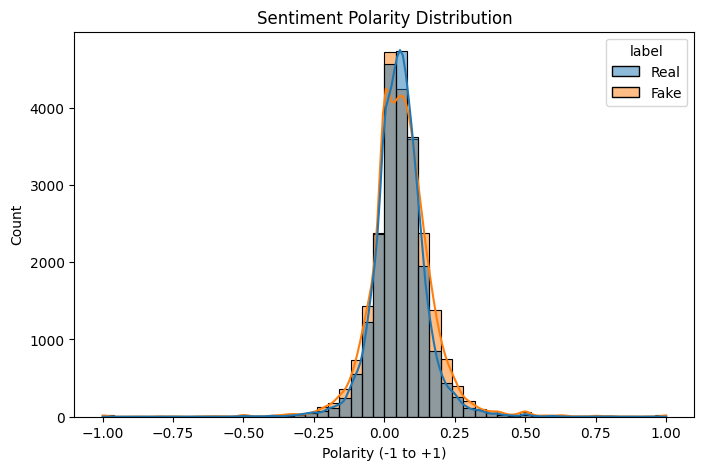

In [21]:
from textblob import TextBlob

df['sentiment'] = df['text'].apply(lambda x: TextBlob(str(x)).sentiment.polarity)

plt.figure(figsize=(8,5))
sns.histplot(data=df, x='sentiment', hue='label', kde=True, bins=50)
plt.title("Sentiment Polarity Distribution")
plt.xlabel("Polarity (-1 to +1)")
plt.show()